# InceptionNet: CIFAR-10 + PyTorch

- refer to _Going deeper with convolutions_ by Christian Szegedy et al. paper.

- modified for CIFAR-10 dataset


In [1]:
# Specify GPU to be used-
# %env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import numpy as np
import os, pickle

from cifar10_dataloader import get_cifar10_data
from InceptionNet_torch import InceptionBlock, InceptionNet

/home/majumdar/anaconda3/envs/torch-cuda-new/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/majumdar/anaconda3/envs/torch-cuda-new/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
print(f"torch version: {torch.__version__}")


# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 1.13.1
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3090
Available device is cuda


In [4]:
# Specify hyper-parameters
batch_size = 256
num_classes = 10
num_epochs = 85

In [5]:
# Get CIFAR-10 datasets-
train_loader, val_loader, train_dataset, val_dataset = get_cifar10_data(
    path_to_files = '/home/majumdar/Downloads/.data/',
    batch_size = batch_size
)

Files already downloaded and verified
Files already downloaded and verified


#### InceptionNet-v1 CNN

modified for CIFAR-10 dataset.

In [6]:
# Define feature map for inception blocks-
feat_map = [
    [64, 96, 128, 16, 32, 32],
    [128, 128, 192, 32, 96, 64],
    [192, 96, 208, 16, 48, 64],
    [160, 112, 224, 24, 64, 64],
    [128, 128, 256, 24, 64, 64],
    [112, 144, 288, 32, 64, 64],
    [256, 160, 320, 32, 128, 128],
    [256, 160, 320, 32, 128, 128],
    [384, 192, 384, 48, 128, 128]
    ]

# inp_channels = [192, 256, 480, 512, 512, 512, 528, 832, 1024]
inp_channels = [64, 352, 576, 672, 672, 704, 752, 1024, 1024]

In [7]:
# Initialize InceptionNet-
model = InceptionNet(
    inp_channels = inp_channels, feat_map = feat_map
).to(device)

In [8]:
def count_trainable_params(model):
    # Count number of layer-wise parameters and total parameters-
    tot_params = 0
    for param in model.parameters():
        # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
        tot_params += param.nelement()

    return tot_params

print(f"InceptionNet has {count_trainable_params(model = model)} params")

InceptionNet has 14849376 params


### Learning Rate Scheduler

Training dataset size = 50K, batch-size = 256, number of training steps per epoch = 50K / 256 = 195.3125

After an initial LR warmup of 13 epochs or, 2539.0625 = 2540 training iterations:

- For the next 32 epochs, or, until $45^{th}$ epoch, use lr = 01.

- For the next 25 epochs, or, until $70^{th}$ epoch, use lr = 0.01.

- For remaninig epochs, use lr = 0.001.

In [9]:
boundaries = [8790, 13672]
values = [0.1, 0.01, 0.001]

In [10]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params = model.parameters(), lr = 0.0,
    momentum = 0.9, weight_decay = 5e-4
)

In [11]:
# Sanity check-
optimizer.param_groups[0]['lr']

0.0

In [12]:
def decay_function(step, boundaries = [8790, 13672], values = [0.1, 0.01, 0.001]):
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]


class schedule():
    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr
        

In [13]:
# Initial linear LR warmup: 195.3125 x 13 = 2540 steps in 13 epochs.
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 2540,
    decay_func = decay_function
)

In [14]:
step = 0

In [15]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)
            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0
    
    # Set model to evaluation mode-
    model.eval()

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()
 

In [16]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

# Initialize parameters saving 'best' models-
best_val_acc = 0

In [17]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model, train_loader,
        train_dataset
    )
    val_loss, val_acc = test_model_progress(
        model, val_loader,
        val_dataset
    )
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          # f" beta = {model.beta.cpu().detach().numpy():.6f} & LR = {optimizer.param_groups[0]['lr']:.5f}\n"
         )
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr'],
        # 'beta': model.beta.cpu().detach().numpy()
    }

    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.4f}%\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "InceptionNet_best_model.pth")
        

Validation: : 100%|███████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=35, val_loss=4.04]



epoch: 1 training loss = 5.9359, training accuracy = 17.96%, val_loss = 4.0389, val_accuracy = 35.02% & 
Saving model with highest val_acc = 35.0200%



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.73batch/s, val_acc=51.7, val_loss=1.71]



epoch: 2 training loss = 2.6668, training accuracy = 41.65%, val_loss = 1.7053, val_accuracy = 51.70% & 
Saving model with highest val_acc = 51.7000%



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.73batch/s, val_acc=61.8, val_loss=1.18]



epoch: 3 training loss = 1.5641, training accuracy = 51.65%, val_loss = 1.1809, val_accuracy = 61.77% & 
Saving model with highest val_acc = 61.7700%



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.66batch/s, val_acc=66.5, val_loss=1.01]



epoch: 4 training loss = 1.2596, training accuracy = 58.11%, val_loss = 1.0099, val_accuracy = 66.49% & 
Saving model with highest val_acc = 66.4900%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.66batch/s, val_acc=69.8, val_loss=0.915]



epoch: 5 training loss = 1.0947, training accuracy = 63.10%, val_loss = 0.9151, val_accuracy = 69.75% & 
Saving model with highest val_acc = 69.7500%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.64batch/s, val_acc=68.1, val_loss=0.971]



epoch: 6 training loss = 0.9812, training accuracy = 66.65%, val_loss = 0.9706, val_accuracy = 68.06% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.66batch/s, val_acc=75.1, val_loss=0.741]



epoch: 7 training loss = 0.9013, training accuracy = 69.48%, val_loss = 0.7406, val_accuracy = 75.15% & 
Saving model with highest val_acc = 75.1500%



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.66batch/s, val_acc=76.7, val_loss=0.69]



epoch: 8 training loss = 0.8386, training accuracy = 71.52%, val_loss = 0.6898, val_accuracy = 76.71% & 
Saving model with highest val_acc = 76.7100%



Validation: : 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.65batch/s, val_acc=76, val_loss=0.727]



epoch: 9 training loss = 0.7857, training accuracy = 73.41%, val_loss = 0.7273, val_accuracy = 76.05% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.66batch/s, val_acc=77.2, val_loss=0.694]



epoch: 10 training loss = 0.7378, training accuracy = 74.96%, val_loss = 0.6944, val_accuracy = 77.17% & 
Saving model with highest val_acc = 77.1700%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=76.4, val_loss=0.728]



epoch: 11 training loss = 0.7140, training accuracy = 75.67%, val_loss = 0.7275, val_accuracy = 76.44% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.69batch/s, val_acc=72.3, val_loss=0.841]



epoch: 12 training loss = 0.6872, training accuracy = 76.41%, val_loss = 0.8410, val_accuracy = 72.31% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.70batch/s, val_acc=77.3, val_loss=0.663]



epoch: 13 training loss = 0.6591, training accuracy = 77.52%, val_loss = 0.6629, val_accuracy = 77.30% & 
Saving model with highest val_acc = 77.3000%



Validation: : 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.70batch/s, val_acc=79, val_loss=0.648]



epoch: 14 training loss = 0.6380, training accuracy = 78.36%, val_loss = 0.6481, val_accuracy = 79.02% & 
Saving model with highest val_acc = 79.0200%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=80.2, val_loss=0.609]



epoch: 15 training loss = 0.6067, training accuracy = 79.42%, val_loss = 0.6092, val_accuracy = 80.19% & 
Saving model with highest val_acc = 80.1900%



Validation: : 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=73, val_loss=0.782]



epoch: 16 training loss = 0.5869, training accuracy = 80.06%, val_loss = 0.7819, val_accuracy = 73.00% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.66batch/s, val_acc=81.7, val_loss=0.536]



epoch: 17 training loss = 0.5773, training accuracy = 80.55%, val_loss = 0.5363, val_accuracy = 81.70% & 
Saving model with highest val_acc = 81.7000%



Validation: : 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.66batch/s, val_acc=80, val_loss=0.598]



epoch: 18 training loss = 0.5557, training accuracy = 81.21%, val_loss = 0.5982, val_accuracy = 79.95% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.66batch/s, val_acc=81.3, val_loss=0.564]



epoch: 19 training loss = 0.5444, training accuracy = 81.57%, val_loss = 0.5638, val_accuracy = 81.28% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.68batch/s, val_acc=81.4, val_loss=0.594]



epoch: 20 training loss = 0.5385, training accuracy = 81.69%, val_loss = 0.5937, val_accuracy = 81.40% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=82.9, val_loss=0.528]



epoch: 21 training loss = 0.5288, training accuracy = 82.04%, val_loss = 0.5275, val_accuracy = 82.88% & 
Saving model with highest val_acc = 82.8800%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=79.5, val_loss=0.625]



epoch: 22 training loss = 0.5251, training accuracy = 82.32%, val_loss = 0.6254, val_accuracy = 79.50% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.77batch/s, val_acc=82.8, val_loss=0.542]



epoch: 23 training loss = 0.5134, training accuracy = 82.54%, val_loss = 0.5415, val_accuracy = 82.84% & 


Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.68batch/s, val_acc=77.4, val_loss=0.69]



epoch: 24 training loss = 0.5118, training accuracy = 82.47%, val_loss = 0.6903, val_accuracy = 77.39% & 


Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=84.9, val_loss=0.46]



epoch: 25 training loss = 0.5041, training accuracy = 83.10%, val_loss = 0.4597, val_accuracy = 84.86% & 
Saving model with highest val_acc = 84.8600%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=74.2, val_loss=0.816]



epoch: 26 training loss = 0.4959, training accuracy = 83.35%, val_loss = 0.8158, val_accuracy = 74.24% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=80.1, val_loss=0.622]



epoch: 27 training loss = 0.4988, training accuracy = 83.11%, val_loss = 0.6218, val_accuracy = 80.08% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=81.3, val_loss=0.582]



epoch: 28 training loss = 0.4927, training accuracy = 83.38%, val_loss = 0.5817, val_accuracy = 81.27% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.65batch/s, val_acc=81.7, val_loss=0.557]



epoch: 29 training loss = 0.4930, training accuracy = 83.40%, val_loss = 0.5566, val_accuracy = 81.65% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=84.3, val_loss=0.477]



epoch: 30 training loss = 0.4898, training accuracy = 83.47%, val_loss = 0.4771, val_accuracy = 84.32% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.68batch/s, val_acc=79.4, val_loss=0.629]



epoch: 31 training loss = 0.4754, training accuracy = 84.00%, val_loss = 0.6286, val_accuracy = 79.36% & 


Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.68batch/s, val_acc=67.2, val_loss=1.23]



epoch: 32 training loss = 0.4754, training accuracy = 84.04%, val_loss = 1.2309, val_accuracy = 67.24% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=73.9, val_loss=0.838]



epoch: 33 training loss = 0.4672, training accuracy = 84.15%, val_loss = 0.8384, val_accuracy = 73.86% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=81.1, val_loss=0.592]



epoch: 34 training loss = 0.4683, training accuracy = 84.30%, val_loss = 0.5918, val_accuracy = 81.08% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=81.3, val_loss=0.571]



epoch: 35 training loss = 0.4681, training accuracy = 84.27%, val_loss = 0.5715, val_accuracy = 81.31% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.68batch/s, val_acc=79.1, val_loss=0.643]



epoch: 36 training loss = 0.4624, training accuracy = 84.32%, val_loss = 0.6434, val_accuracy = 79.15% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.68batch/s, val_acc=84.8, val_loss=0.471]



epoch: 37 training loss = 0.4616, training accuracy = 84.29%, val_loss = 0.4706, val_accuracy = 84.75% & 


Validation: : 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=84, val_loss=0.483]



epoch: 38 training loss = 0.4550, training accuracy = 84.79%, val_loss = 0.4833, val_accuracy = 84.02% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=82.7, val_loss=0.518]



epoch: 39 training loss = 0.4462, training accuracy = 85.00%, val_loss = 0.5180, val_accuracy = 82.68% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.70batch/s, val_acc=85.2, val_loss=0.456]



epoch: 40 training loss = 0.4462, training accuracy = 85.15%, val_loss = 0.4556, val_accuracy = 85.22% & 
Saving model with highest val_acc = 85.2200%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=84.3, val_loss=0.482]



epoch: 41 training loss = 0.4492, training accuracy = 85.08%, val_loss = 0.4819, val_accuracy = 84.30% & 


Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=82.8, val_loss=0.54]



epoch: 42 training loss = 0.4390, training accuracy = 85.33%, val_loss = 0.5397, val_accuracy = 82.78% & 


Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.72batch/s, val_acc=83.6, val_loss=0.51]



epoch: 43 training loss = 0.4373, training accuracy = 85.24%, val_loss = 0.5097, val_accuracy = 83.60% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.70batch/s, val_acc=83.2, val_loss=0.529]



epoch: 44 training loss = 0.4361, training accuracy = 85.38%, val_loss = 0.5288, val_accuracy = 83.22% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.69batch/s, val_acc=91.2, val_loss=0.266]



epoch: 45 training loss = 0.4276, training accuracy = 85.80%, val_loss = 0.2661, val_accuracy = 91.17% & 
Saving model with highest val_acc = 91.1700%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.70batch/s, val_acc=92.7, val_loss=0.221]



epoch: 46 training loss = 0.2667, training accuracy = 91.10%, val_loss = 0.2206, val_accuracy = 92.74% & 
Saving model with highest val_acc = 92.7400%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.71batch/s, val_acc=93.4, val_loss=0.203]



epoch: 47 training loss = 0.2283, training accuracy = 92.29%, val_loss = 0.2025, val_accuracy = 93.39% & 
Saving model with highest val_acc = 93.3900%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.71batch/s, val_acc=93.3, val_loss=0.207]



epoch: 48 training loss = 0.2069, training accuracy = 93.03%, val_loss = 0.2065, val_accuracy = 93.31% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.70batch/s, val_acc=93.4, val_loss=0.201]



epoch: 49 training loss = 0.1942, training accuracy = 93.56%, val_loss = 0.2014, val_accuracy = 93.36% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.69batch/s, val_acc=93.7, val_loss=0.191]



epoch: 50 training loss = 0.1836, training accuracy = 93.83%, val_loss = 0.1909, val_accuracy = 93.65% & 
Saving model with highest val_acc = 93.6500%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.72batch/s, val_acc=93.8, val_loss=0.198]



epoch: 51 training loss = 0.1754, training accuracy = 94.23%, val_loss = 0.1981, val_accuracy = 93.78% & 
Saving model with highest val_acc = 93.7800%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.69batch/s, val_acc=93.7, val_loss=0.197]



epoch: 52 training loss = 0.1689, training accuracy = 94.42%, val_loss = 0.1975, val_accuracy = 93.68% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.70batch/s, val_acc=93.4, val_loss=0.209]



epoch: 53 training loss = 0.1619, training accuracy = 94.67%, val_loss = 0.2085, val_accuracy = 93.41% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.68batch/s, val_acc=93.8, val_loss=0.194]



epoch: 54 training loss = 0.1572, training accuracy = 94.85%, val_loss = 0.1939, val_accuracy = 93.82% & 
Saving model with highest val_acc = 93.8200%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.68batch/s, val_acc=93.9, val_loss=0.197]



epoch: 55 training loss = 0.1516, training accuracy = 95.04%, val_loss = 0.1969, val_accuracy = 93.87% & 
Saving model with highest val_acc = 93.8700%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.68batch/s, val_acc=93.7, val_loss=0.201]



epoch: 56 training loss = 0.1476, training accuracy = 95.25%, val_loss = 0.2006, val_accuracy = 93.71% & 


Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.68batch/s, val_acc=93.8, val_loss=0.19]



epoch: 57 training loss = 0.1436, training accuracy = 95.41%, val_loss = 0.1896, val_accuracy = 93.78% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.70batch/s, val_acc=93.8, val_loss=0.198]



epoch: 58 training loss = 0.1357, training accuracy = 95.55%, val_loss = 0.1983, val_accuracy = 93.77% & 


Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.72batch/s, val_acc=94.1, val_loss=0.19]



epoch: 59 training loss = 0.1337, training accuracy = 95.65%, val_loss = 0.1904, val_accuracy = 94.14% & 
Saving model with highest val_acc = 94.1400%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.72batch/s, val_acc=93.9, val_loss=0.196]



epoch: 60 training loss = 0.1293, training accuracy = 95.83%, val_loss = 0.1957, val_accuracy = 93.92% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.69batch/s, val_acc=93.9, val_loss=0.198]



epoch: 61 training loss = 0.1282, training accuracy = 95.88%, val_loss = 0.1976, val_accuracy = 93.93% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.68batch/s, val_acc=93.9, val_loss=0.196]



epoch: 62 training loss = 0.1265, training accuracy = 95.93%, val_loss = 0.1964, val_accuracy = 93.90% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.72batch/s, val_acc=93.9, val_loss=0.202]



epoch: 63 training loss = 0.1220, training accuracy = 96.06%, val_loss = 0.2024, val_accuracy = 93.94% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=93.9, val_loss=0.198]



epoch: 64 training loss = 0.1183, training accuracy = 96.16%, val_loss = 0.1982, val_accuracy = 93.90% & 


Validation: : 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.71batch/s, val_acc=94, val_loss=0.203]



epoch: 65 training loss = 0.1174, training accuracy = 96.28%, val_loss = 0.2032, val_accuracy = 93.95% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.71batch/s, val_acc=93.5, val_loss=0.212]



epoch: 66 training loss = 0.1148, training accuracy = 96.32%, val_loss = 0.2117, val_accuracy = 93.49% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=93.9, val_loss=0.198]



epoch: 67 training loss = 0.1152, training accuracy = 96.38%, val_loss = 0.1976, val_accuracy = 93.92% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.71batch/s, val_acc=93.7, val_loss=0.204]



epoch: 68 training loss = 0.1096, training accuracy = 96.52%, val_loss = 0.2039, val_accuracy = 93.67% & 


Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.72batch/s, val_acc=93.7, val_loss=0.21]



epoch: 69 training loss = 0.1055, training accuracy = 96.67%, val_loss = 0.2096, val_accuracy = 93.66% & 


Validation: : 100%|██████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=94, val_loss=0.196]



epoch: 70 training loss = 0.1090, training accuracy = 96.50%, val_loss = 0.1963, val_accuracy = 93.97% & 


Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.70batch/s, val_acc=94.2, val_loss=0.19]



epoch: 71 training loss = 0.0901, training accuracy = 97.31%, val_loss = 0.1902, val_accuracy = 94.16% & 
Saving model with highest val_acc = 94.1600%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=94.2, val_loss=0.191]



epoch: 72 training loss = 0.0842, training accuracy = 97.44%, val_loss = 0.1911, val_accuracy = 94.18% & 
Saving model with highest val_acc = 94.1800%



Validation: : 100%|█████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.72batch/s, val_acc=94.3, val_loss=0.19]



epoch: 73 training loss = 0.0820, training accuracy = 97.60%, val_loss = 0.1896, val_accuracy = 94.29% & 
Saving model with highest val_acc = 94.2900%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.69batch/s, val_acc=94.3, val_loss=0.189]



epoch: 74 training loss = 0.0788, training accuracy = 97.66%, val_loss = 0.1890, val_accuracy = 94.26% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.68batch/s, val_acc=94.2, val_loss=0.189]



epoch: 75 training loss = 0.0744, training accuracy = 97.76%, val_loss = 0.1887, val_accuracy = 94.23% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.69batch/s, val_acc=94.4, val_loss=0.187]



epoch: 76 training loss = 0.0750, training accuracy = 97.80%, val_loss = 0.1866, val_accuracy = 94.37% & 
Saving model with highest val_acc = 94.3700%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.69batch/s, val_acc=94.3, val_loss=0.188]



epoch: 77 training loss = 0.0741, training accuracy = 97.78%, val_loss = 0.1878, val_accuracy = 94.35% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.71batch/s, val_acc=94.3, val_loss=0.189]



epoch: 78 training loss = 0.0721, training accuracy = 97.87%, val_loss = 0.1888, val_accuracy = 94.32% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.68batch/s, val_acc=94.4, val_loss=0.189]



epoch: 79 training loss = 0.0706, training accuracy = 97.98%, val_loss = 0.1891, val_accuracy = 94.38% & 
Saving model with highest val_acc = 94.3800%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.69batch/s, val_acc=94.3, val_loss=0.189]



epoch: 80 training loss = 0.0705, training accuracy = 97.98%, val_loss = 0.1885, val_accuracy = 94.26% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.74batch/s, val_acc=94.3, val_loss=0.187]



epoch: 81 training loss = 0.0695, training accuracy = 97.93%, val_loss = 0.1875, val_accuracy = 94.33% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.69batch/s, val_acc=94.5, val_loss=0.187]



epoch: 82 training loss = 0.0674, training accuracy = 98.03%, val_loss = 0.1868, val_accuracy = 94.47% & 
Saving model with highest val_acc = 94.4700%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=94.4, val_loss=0.185]



epoch: 83 training loss = 0.0675, training accuracy = 97.96%, val_loss = 0.1848, val_accuracy = 94.40% & 


Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.68batch/s, val_acc=94.5, val_loss=0.188]



epoch: 84 training loss = 0.0672, training accuracy = 98.07%, val_loss = 0.1877, val_accuracy = 94.51% & 
Saving model with highest val_acc = 94.5100%



Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67batch/s, val_acc=94.3, val_loss=0.188]


epoch: 85 training loss = 0.0679, training accuracy = 98.00%, val_loss = 0.1884, val_accuracy = 94.33% & 


In [18]:
# Save training metrics as Python3 history for later analysis-
with open("InceptionNet_training_history.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

### Training Visualizations

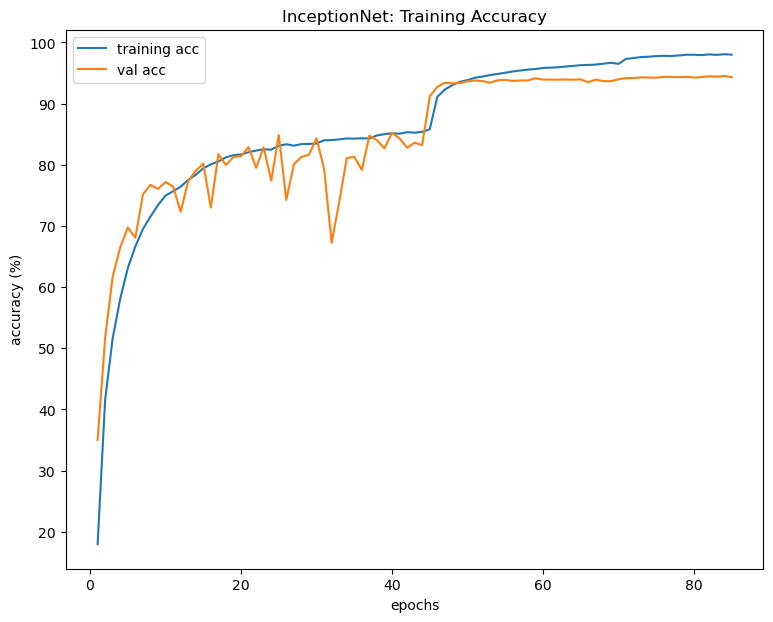

In [19]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("InceptionNet: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

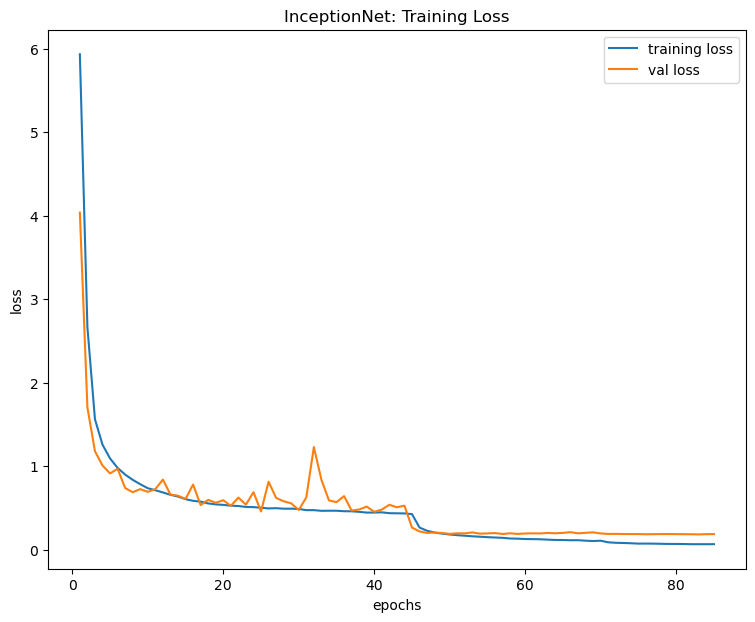

In [20]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("InceptionNet: Training Loss")
plt.show()

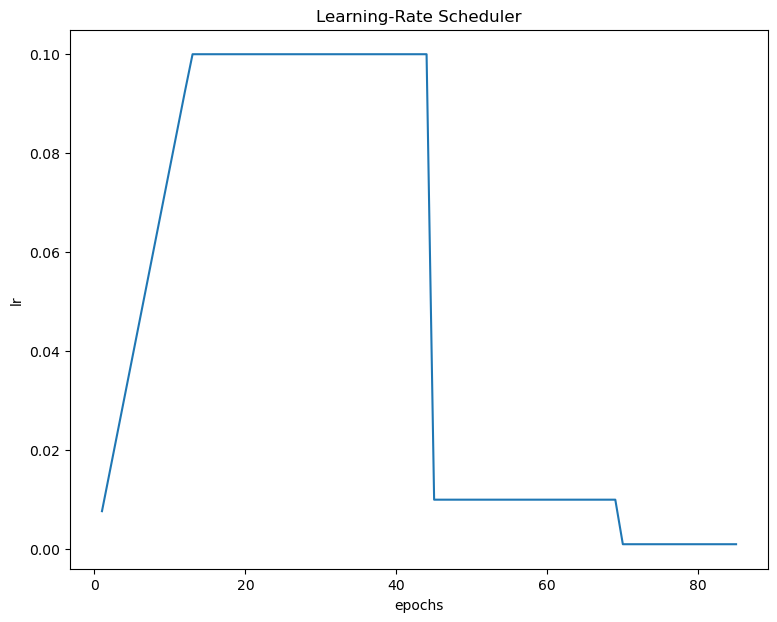

In [21]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("Learning-Rate Scheduler")
plt.show()

In [ ]:
'''
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['beta'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("InceptionNet: Swish (beta) activation function")
plt.show()
'''

In [22]:
del model

In [ ]:
# Initialize and load 'best' trained parameters from above-
best_model = InceptionNet(
    inp_channels = inp_channels,
    feat_map = feat_map
)
best_model.load_state_dict(torch.load("InceptionNet_best_model.pth"))

# Move to GPU device-
best_model.to(device)

In [26]:
# Get validation metrics of 'best' trained model-
val_loss, val_acc = test_model_progress(
    model = best_model, test_loader = val_loader,
    test_dataset = val_dataset
)

Validation: : 100%|████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.74batch/s, val_acc=94.5, val_loss=0.188]


In [27]:
print("InceptionNet 'best' trained validation metrics: ",
      f"loss = {val_loss:.4f} & acc = {val_acc:.2f}%"
     )

InceptionNet 'best' trained validation metrics:  loss = 0.1877 & acc = 94.51%
